### Step1: crop cells region by region

similar to seqscope's step4\
start from this step becuase stereoseq data is large, so early steps are not included, also becuase stereoseq image and ST data are already aligned

**note**, need to manually change which region working on\
**note**, dd=5, centers detected are all 5 units away from cell boundary

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
import cv2
from collections import defaultdict
import timeit
# pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
##### specify region index
# regions
# 1 image[26000:33000,9500:18000] | 2 image[26000:33000,18000:26460]
# 3 image[19000:26000,9500:18000] | 4 image[19000:26000,18000:26460]
# 5 image[12000:19000,9500:18000] | 6 image[12000:19000,18000:26460]
# 7 image[5500:12000,9500:18000]  | 8 image[5500:12000,18000:26460]

r = 7        # <<<<<
rx1 = 5500   # <<<<<
rx2 = 12000  # <<<<<
ry1 = 9500   # <<<<<
ry2 = 18000  # <<<<<

print(f'===== working on region r={r}\n')

===== working on region r=7



In [3]:
##### load cellpose segmentation
print('===== read data:\n')

filename = '../input/R'+str(r)+'_seg.npy'
dat = np.load(filename, allow_pickle=True).item()
print(dat.keys())
print('img', dat['img'].shape)
print('outlines', dat['outlines'].shape)
print('masks', dat['masks'].shape, np.amin(dat['masks']), np.amax(dat['masks']))

===== read data:

dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])
img (6500, 8500)
outlines (6500, 8500)
masks (6500, 8500) 0 44327


In [4]:
##### read bin1 data provided by stereoseq
filename = '../input/E16.5_E1S3_GEM_bin1.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
bin1_ = pickle_dict['bin1_df']
print(bin1_.head())
bin1 = bin1_.rename({'MIDCount': 'umi'}, axis=1)
print(bin1.head())

  geneID      x      y  MIDCount
0    Cr2  16118  19912         1
1    Cr2  13889  19182         1
2    Cr2  24801  25748         1
3    Cr2  15273  24153         1
4    Cr2  11997  15366         1
  geneID      x      y  umi
0    Cr2  16118  19912    1
1    Cr2  13889  19182    1
2    Cr2  24801  25748    1
3    Cr2  15273  24153    1
4    Cr2  11997  15366    1


In [5]:
##### read unsp data (un-processed)
filename = '../input/unsp_df_dict.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
unsp_ = pickle_dict['unsp_df']
print(unsp_.head())
# switch x y
unsp2_ = unsp_.rename({'x': 'y', 'y': 'x'}, axis=1)
print(unsp2_.head())
# groupby coord
unsp = unsp2_.groupby(['x', 'y']).sum().reset_index()
print(unsp.head())

         x        y  umi
0  22269.0  14803.0    1
1  22331.0   7932.0    1
2  26290.0  23043.0    1
3  18736.0  27304.0    3
4  17801.0  13529.0    2
         y        x  umi
0  22269.0  14803.0    1
1  22331.0   7932.0    1
2  26290.0  23043.0    1
3  18736.0  27304.0    3
4  17801.0  13529.0    2
      x        y  umi
0   2.0    623.0    2
1   5.0  25469.0    1
2   6.0  23943.0    1
3   8.0  10990.0    6
4  10.0   4595.0    2


In [6]:
##### read sp data (un-processed)
filename = '../input/sp_df_dict.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
sp_ = pickle_dict['sp_df']
print(sp_.head())
# switch x y
sp2_ = sp_.rename({'x': 'y', 'y': 'x'}, axis=1).copy()
print(sp2_.head())
# groupby coord
sp = sp2_.groupby(['x', 'y']).sum().reset_index().copy()
print(sp.head())

         x        y  umi
0  13509.0  28563.0    1
1  22331.0   7932.0    1
2  18602.0  15959.0    2
3  20770.0  26462.0    1
4  10880.0  21763.0    1
         y        x  umi
0  13509.0  28563.0    1
1  22331.0   7932.0    1
2  18602.0  15959.0    2
3  20770.0  26462.0    1
4  10880.0  21763.0    1
     x        y  umi
0  0.0  14690.0    8
1  0.0  18850.0    1
2  1.0   9194.0    1
3  1.0  19349.0    4
4  2.0   4038.0    1


In [7]:
##### get bin1, unsp, sp on the region
# bin1_r - region
filter1 = bin1.x >= rx1
filter2 = bin1.x < rx2
filter3 = bin1.y >= ry1
filter4 = bin1.y < ry2
bin1_r = bin1[filter1 & filter2 & filter3 & filter4]
bin1_r['xr'] = bin1_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
bin1_r['yr'] = bin1_r.y.copy() - ry1
print(bin1_r.head())

# unsp_r - region
filter1 = unsp.x >= rx1
filter2 = unsp.x < rx2
filter3 = unsp.y >= ry1
filter4 = unsp.y < ry2
unsp_r = unsp[filter1 & filter2 & filter3 & filter4]
unsp_r['xr'] = unsp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
unsp_r['yr'] = unsp_r.y.copy() - ry1
print(unsp_r.head())

# sp_r - region
filter1 = sp.x >= rx1
filter2 = sp.x < rx2
filter3 = sp.y >= ry1
filter4 = sp.y < ry2
sp_r = sp[filter1 & filter2 & filter3 & filter4].copy()
sp_r['xr'] = sp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
sp_r['yr'] = sp_r.y.copy() - ry1
print(sp_r.head())

/tmp/ipykernel_32840/2840753512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['xr'] = bin1_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
/tmp/ipykernel_32840/2840753512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['yr'] = bin1_r.y.copy() - ry1


   geneID      x      y  umi    xr    yr
4     Cr2  11997  15366    1  6497  5866
8     Cr2  10286  17055    1  4786  7555
45   Cr1l   6777   9601    1  1277   101
55   Cr1l   7187  16458    1  1687  6958
58   Cr1l   7504  15188    1  2004  5688


/tmp/ipykernel_32840/2840753512.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['xr'] = unsp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
/tmp/ipykernel_32840/2840753512.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['yr'] = unsp_r.y.copy() - ry1


             x       y  umi   xr     yr
939254  5500.0  9642.0    1  0.0  142.0
939255  5500.0  9773.0    1  0.0  273.0
939256  5500.0  9852.0    1  0.0  352.0
939257  5500.0  9912.0    1  0.0  412.0
939258  5500.0  9982.0    1  0.0  482.0
              x       y  umi   xr    yr
3711078  5500.0  9514.0    1  0.0  14.0
3711079  5500.0  9515.0    1  0.0  15.0
3711080  5500.0  9552.0    1  0.0  52.0
3711081  5500.0  9585.0    1  0.0  85.0
3711082  5500.0  9597.0    6  0.0  97.0


In [8]:
##### compute unspMat_r, spMat_r on the region

# kernal size
kn = 10 # <<<<<
# circle kernal for computing local density
kernalCir = np.zeros((kn,kn))
for i in range(kn):
    for j in range(kn):
        if (i-int(kn/2)-1)*(i-int(kn/2)-1) + (j-int(kn/2)-1)*(j-int(kn/2)-1) < kn*kn/4:
            kernalCir[i,j] = 1

start = timeit.default_timer()

# unsp matrix
unspMat_r = np.zeros((int(unsp_r.xr.max()), int(unsp_r.yr.max())), dtype=int)
print(unspMat_r.shape)
# compute unspMat
for i in range(unsp_r.xr.size):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/unsp_r.xr.size)) # percentage progress
        sys.stdout.flush()
    xi = unsp_r.xr.iloc[i]
    yi = unsp_r.yr.iloc[i]
    try:
        unspMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] = unspMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] + unsp_r.umi.iloc[i]*kernalCir
    except:
        pass

# sp matrix
spMat_r = np.zeros((int(sp_r.xr.max()), int(sp_r.yr.max())), dtype=int)
print(spMat_r.shape)
# compute spMat
for i in range(sp_r.xr.size):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/sp_r.xr.size)) # percentage progress
        sys.stdout.flush()
    xi = sp_r.xr.iloc[i]
    yi = sp_r.yr.iloc[i]
    try:
        spMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] = spMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] + sp_r.umi.iloc[i]*kernalCir
    except:
        pass

stop = timeit.default_timer()
print('\n Time: ', stop - start) # ~948s

(6499, 8499)
0.999731738650128944(6499, 8499)
0.995228752320042977
 Time:  705.1379411183298


In [9]:
##### check if dim match
print(dat['img'].shape)
print(unsp_r.xr.max()+1, unsp_r.yr.max()+1)

(6500, 8500)
6500.0 8500.0


In [10]:
##### find cell label for bin1_r and unsp_r
print('===== find cell label:\n')

# mask
mask_r = dat['masks']

# find cell label for bin1_r
start = timeit.default_timer()
label = []
for i in range(len(bin1_r)):
    l = mask_r[int(bin1_r['xr'].iloc[i]), int(bin1_r['yr'].iloc[i])]
    label.append(l)
stop = timeit.default_timer()
print('Time: ', stop - start) # ~792s
# append label to bin1_r
bin1_r['cell'] = np.array(label)
print(bin1_r.head())
# remove unlabled cell (cell=0)
bin1_seg_r = bin1_r[bin1_r.cell>0]
print(bin1_seg_r.head())

# find cell label for unsp_r
start = timeit.default_timer()
label = []
for i in range(len(unsp_r)):
    l = mask_r[int(unsp_r['xr'].iloc[i]), int(unsp_r['yr'].iloc[i])]
    label.append(l)
stop = timeit.default_timer()
print('Time: ', stop - start) # ~62s
# append label to bin1_r
unsp_r['cell'] = np.array(label)
print(unsp_r.head())
# remove unlabled cell (cell=0)
unsp_seg_r = unsp_r[unsp_r.cell>0]
print(unsp_seg_r.head())

===== find cell label:

Time:  610.6664686938748
   geneID      x      y  umi    xr    yr  cell
4     Cr2  11997  15366    1  6497  5866     0
8     Cr2  10286  17055    1  4786  7555     0
45   Cr1l   6777   9601    1  1277   101     0
55   Cr1l   7187  16458    1  1687  6958     0
58   Cr1l   7504  15188    1  2004  5688     0


/tmp/ipykernel_32840/181365738.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['cell'] = np.array(label)


    geneID      x      y  umi    xr    yr   cell
135   Cr1l   9341  14664    1  3841  5164  19341
215   Cr1l   6789  17959    2  1289  8459   2898
223   Cr1l  11394  12311    1  5894  2811  36376
271   Cr1l   6644  17419    1  1144  7919   1691
280   Cr1l  10414  15178    1  4914  5678  28549
Time:  49.19251914136112
             x       y  umi   xr     yr  cell
939254  5500.0  9642.0    1  0.0  142.0     0
939255  5500.0  9773.0    1  0.0  273.0     0
939256  5500.0  9852.0    1  0.0  352.0     0
939257  5500.0  9912.0    1  0.0  412.0     0
939258  5500.0  9982.0    1  0.0  482.0     0


/tmp/ipykernel_32840/181365738.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['cell'] = np.array(label)


              x        y  umi     xr      yr  cell
1047818  5814.0  15604.0    1  314.0  6104.0     1
1048250  5815.0  15585.0    1  315.0  6085.0     1
1048251  5815.0  15586.0    2  315.0  6086.0     1
1048252  5815.0  15592.0    2  315.0  6092.0     1
1048253  5815.0  15600.0    1  315.0  6100.0     1


In [11]:
##### find cell center with unsp_seg_r
print('===== find cell center:\n')

# min dis from center to boundary
# feasible domain for maxima search as cell center
dd = 5 # <<<<<
print('dd='+str(dd))

crop_cell_buffer_distance = 5 # croping a larger region than the actual cell region to avoid potential error
npad = 1 # padding width in a intermidate step
erosion_kernel = np.ones((2*dd+1, 2*dd+1), np.uint8) # erosion kernal 

bin1_seg_r_gbC = bin1_seg_r.groupby('cell')
cellUnique = unsp_seg_r.cell.unique().tolist()

start = timeit.default_timer()

centers = [] # unsp centers
for i, c in enumerate(cellUnique):
    if i % 1e3 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(cellUnique))) # percentage progress
        sys.stdout.flush()
    try:
        bin1_seg_r_c = bin1_seg_r_gbC.get_group(c).copy()
        xmin_ = bin1_seg_r_c.xr.min()
        xmax_ = bin1_seg_r_c.xr.max()
        ymin_ = bin1_seg_r_c.yr.min()
        ymax_ = bin1_seg_r_c.yr.max()

        unspMat_r_c = unspMat_r[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]
        mask_r_c = mask_r[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]

        # process mask_t_c
        mask_r_c_binary = (mask_r_c == c).astype(np.uint8) # binary mask
        mask_r_c_binary_padded = np.pad(mask_r_c_binary, npad, mode='constant') # pad for better erosion
        mask_r_c_binary_padded_erosion = cv2.erode(mask_r_c_binary_padded, erosion_kernel, iterations=1) # erosion
        mask_r_c_binary_padded_erosion_depadded = mask_r_c_binary_padded_erosion[npad:-npad,npad:-npad] # remove padding

        # keep unspliced density within the desired area, and looking for maximum
        unspmask_r_c = unspMat_r_c*mask_r_c_binary_padded_erosion_depadded
        center_c = np.where(unspmask_r_c == unspmask_r_c.max())
        center_c2 = [round(np.mean(center_c[0])+(xmin_-crop_cell_buffer_distance)), round(np.mean(center_c[1])+(ymin_-crop_cell_buffer_distance))]

        # save detected center, cell label, and unspliced density value at center
        centers.append([center_c2[0], center_c2[1], c, unspmask_r_c.max()])

        unspmask_r_c = unspMat_r_c*(mask_r_c == c)
    except:
        centers.append([0,0,c,0])  
stop = timeit.default_timer()
print('Time: ', stop - start) 
print('#centers', len(centers)) # ~57s
centers_bkp = centers

===== find cell center:

dd=5
0.992802184164805166Time:  42.45975682884455
#centers 44319


In [12]:
##### keep cells with unspMat[center] > q1
q1=np.quantile(unspMat_r, 0.95) # <<<<<
print('q1 =', q1)
centers1 = np.array(centers)[np.array(centers)[:,3] >= q1,:]
print(centers1.shape)

q1 = 61.0
(10506, 4)


In [13]:
##### keep cells with spMat[center] < q2
q2=np.quantile(spMat_r, 0.95)
print('q2 =', q2)
centers2 = []
for i in range(centers1.shape[0]):
    if spMat_r[centers1[i,0], centers1[i,1]] <= q2:
        centers2.append(centers1[i,:])
centers2 = np.array(centers2)
print(centers2.shape)

q2 = 317.0
(9922, 4)


In [14]:
##### append cell centers to bin1_seg_r
# bin1_seg_r
data = bin1_seg_r['cell'].tolist()
keys = np.array(centers2)[:,2]
vals = np.array(centers2)[:,:2]
memo = defaultdict(lambda: (0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))

print(len(res0), len(data), len(keys), len(vals))

bin1_seg_r['centerX_r'] = np.array(res0)
bin1_seg_r['centerY_r'] = np.array(res1)
print(bin1_seg_r.head())

bin1_seg_r = bin1_seg_r[(bin1_seg_r.centerX_r>0) & (bin1_seg_r.centerY_r>0)].copy()

bin1_seg_r['centerX'] = bin1_seg_r['centerX_r'].copy() + rx1
bin1_seg_r['centerY'] = bin1_seg_r['centerY_r'].copy() + ry1
print(bin1_seg_r.head())

19494205 19494205 9922 9922


/tmp/ipykernel_32840/4070195005.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_seg_r['centerX_r'] = np.array(res0)
/tmp/ipykernel_32840/4070195005.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_seg_r['centerY_r'] = np.array(res1)


    geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r
135   Cr1l   9341  14664    1  3841  5164  19341          0          0
215   Cr1l   6789  17959    2  1289  8459   2898          0          0
223   Cr1l  11394  12311    1  5894  2811  36376          0          0
271   Cr1l   6644  17419    1  1144  7919   1691          0          0
280   Cr1l  10414  15178    1  4914  5678  28549       4913       5668
      geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r  \
280     Cr1l  10414  15178    1  4914  5678  28549       4913       5668   
496     Cd46   9897  17762    1  4397  8262  24157       4397       8266   
498     Cd46   8447  16266    1  2947  6766  13287       2948       6772   
523     Cd46   9508  15306    1  4008  5806  20973       4017       5793   
548  Gm16897   9975  15836    1  4475  6336  24860       4476       6337   

     centerX  centerY  
280    10413    15168  
496     9897    17766  
498     8448    16272  
523     9517    15293

===== viz overlay:



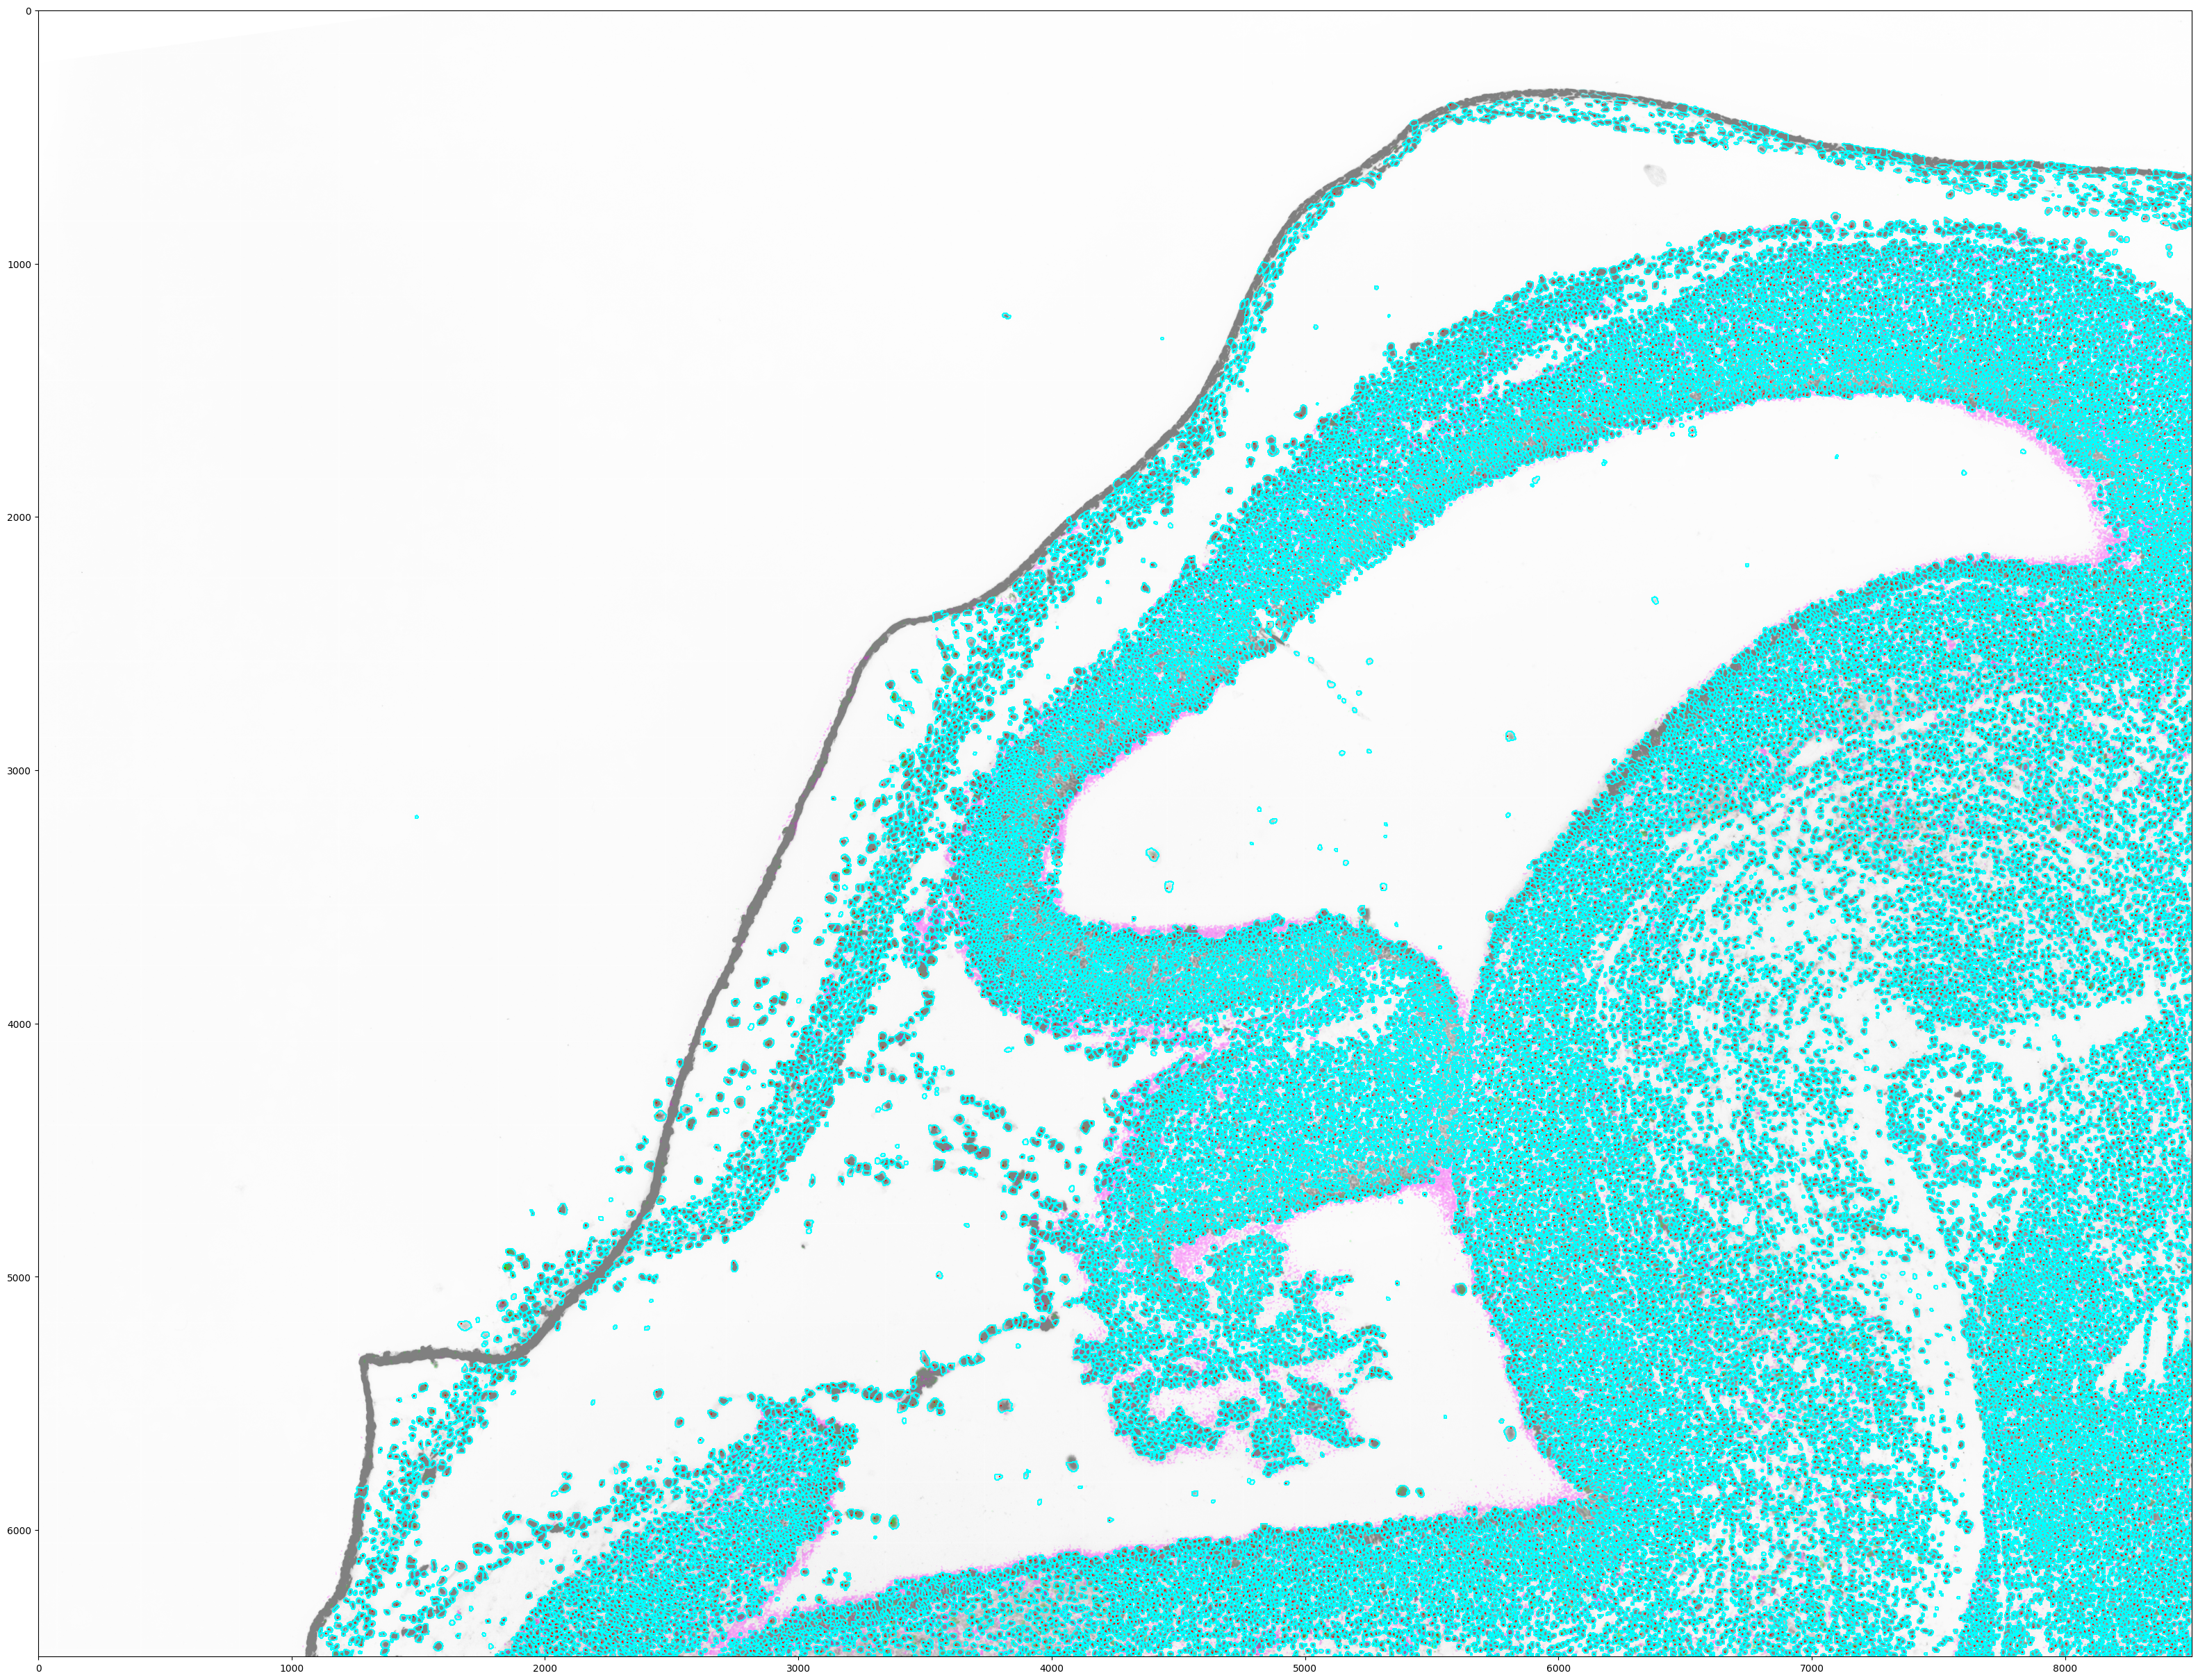

In [15]:
##### viz overlay
print('===== viz overlay:\n')

##### define alpha colormaps
try:
    # black alpha
    color_array = np.zeros([10,4])
    color_array[:,-1] = np.linspace(0,0.1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='black_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # red alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='red_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # green alpha
    color_array = np.zeros([10,4])
    color_array[:,1] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='green_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # blue alpha
    color_array = np.zeros([10,4])
    color_array[:,1] = 1
    color_array[:,2] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='blue_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # pink alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,2] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='pink_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # orange alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,1] = 0.39
    color_array[:,2] = 0.28
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='orange_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
except:
    pass

fig, ax = plt.subplots(1,1, figsize=(40,32))
# image
ax.imshow(dat['img'],
          cmap='Greys',
          alpha=0.5,
          origin='upper')

# bin1_r
# ax.scatter(bin1_r.yr,
#            bin1_r.xr,
#            c=bin1_r.umi,
#            s=1,
#            vmin=0,
#            vmax=bin1_r.umi.quantile(.9999),
#            cmap = 'pink_alpha',
#            alpha=0.1,
#            marker='.')

# sp_r
ax.imshow(spMat_r*(spMat_r>q2),
#           vmin=0,
#           vmax=np.quantile(spMat_r, 0.9),
          cmap='pink_alpha',
          alpha=1,
          origin='upper')

# unsp_r
# ax.scatter(unsp_r.yr,
#            unsp_r.xr,
#            c=unsp_r.umi,
#            s=1,
#            vmin=0,
#            vmax=unsp_r.umi.quantile(.9),
#            cmap = 'green_alpha',
#            alpha=0.8,
#            marker='.')
ax.imshow(unspMat_r*(unspMat_r>q1),
#           vmin=0,
#           vmax=np.quantile(unspMat_r, 0.9),
          cmap='green_alpha',
          alpha=1,
          origin='upper')

# seg
ax.imshow(dat['outlines'],
          vmin=0,
          vmax=2,
          cmap='blue_alpha',
          origin='upper')

c_arr = np.array(centers2)
ax.scatter(c_arr[:,1],
           c_arr[:,0],
           c='red',
           marker='+',
           s=2)

ax.set_aspect('equal', adjustable='box')
ax.grid(False)
fig.savefig('../output_fig/step1_R'+str(r)+'.pdf', dpi=200)

In [16]:
##### save bin1 data with cell label and cell center
print('===== save data:\n')

# save bin1_seg_r
outfile = '../output_step1/crop_R'+str(r)+'_dict.pkl'
# save
pickle_dict = {}
pickle_dict['bin1'] = bin1_seg_r
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)
# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# bin1 = pickle_dict['bin1']

print('===== region ' + str(r) + ' all done!\n')

===== save data:

===== region 7 all done!

